## Formula guessing
Has almost no use but it's a testing experience.

### Import dependencies

In [161]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

# Helper libraries
import numpy as np

### Helper functions

In [162]:
def solve_equation(operations):
  operator_options = {
    1: lambda x, y: x + y,
    2: lambda x, y: x - y
  }
  return operator_options[operations[1]](operations[0], operations[2])

def generate_dataset(amount, max_digit = 9):
  dataset = []
  for i in range(amount):
    digits = np.random.randint(low=0, high=max_digit + 1, size=2)
    operator = np.random.randint(low=1, high=2 + 1, size=1)[0]
    data = [int(digits[0]), int(operator), int(digits[1])]
    solution = solve_equation(data)
    data.append(solution)
    dataset.append(data)
  return dataset

### Setup

In [163]:
checkpoint_path = 'checkpoints/formula_guesser/formula_guesser.ckpt'

tqdm_callback = tfa.callbacks.TQDMProgressBar(
  show_epoch_progress=False
)

### Prepare training and validation data

In [223]:
training_dataset = generate_dataset(100000, max_digit=50)
validation_dataset = generate_dataset(100000, max_digit=50)

### Compile model

In [215]:
model = keras.Sequential([
  keras.layers.Input(shape=(3,), name='digits_and_operator'),
  keras.layers.Dense(units=3*256, activation=keras.activations.relu, name='dense_1'),
  keras.layers.Dense(units=1, activation=keras.activations.linear, name='solution')
], name='formula_guesser')
model.summary()
model.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.0001),
  loss=keras.losses.MeanSquaredError()
)

Model: "formula_guesser"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 768)               3072      
_________________________________________________________________
solution (Dense)             (None, 1)                 769       
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________


### Train model

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

3125/3125 - 1s - loss: 0.5582


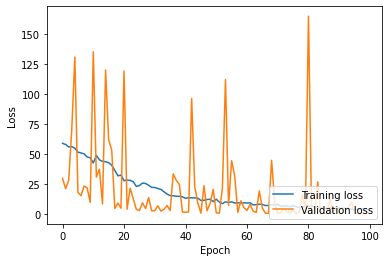

In [224]:
trainXs = list(map(lambda x: x[:3], training_dataset))
trainYs = list(map(lambda x: x[-1], training_dataset))

validationXs = list(map(lambda x: x[:3], validation_dataset))
validationYs = list(map(lambda x: x[-1], validation_dataset))

training_history = model.fit(
  x=trainXs,
  y=trainYs,
  epochs=100,
  batch_size=128,
  validation_data=(validationXs, validationYs),
  verbose=0,
  callbacks=[tqdm_callback]
)

plt.plot(training_history.history['loss'], label='Training loss')
plt.plot(training_history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

model.evaluate(trainXs, trainYs, verbose=2)
plt.show()

### Save checkpoint

In [227]:
model.save_weights(checkpoint_path)

### Load checkpoint

In [228]:
model.load_weights(checkpoint_path)

### Test model

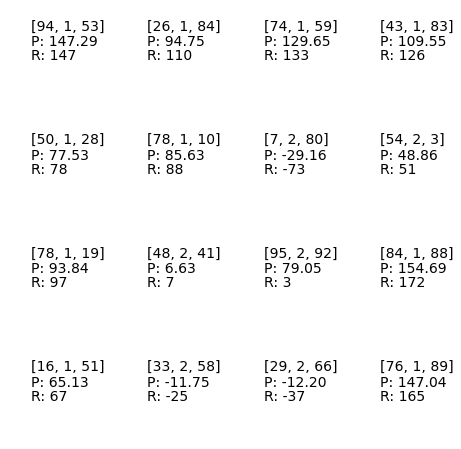

In [230]:
testing_dataset = generate_dataset(4 * 4, max_digit=99)
testingXs = list(map(lambda x: x[:3], testing_dataset))
testingYs = list(map(lambda x: x[-1], testing_dataset))

predictions = model.predict(testingXs)

plt.figure(figsize=(8, 8))
for i in range(len(predictions)):
  plt.subplot(4, 4, i+1)
  plt.imshow([[0, 0], [0, 0]], cmap='binary')

  equation = testingXs[i]
  predicted = predictions[i][0]
  real = testingYs[i]

  plt.annotate(equation, xy=(0, 0), xytext=(0, 0), fontsize=14)
  plt.annotate(f'P: {predicted:.2f}', xy=(0, 0), xytext=(0, 0.325), fontsize=14)
  plt.annotate(f'R: {real}', xy=(0, 0), xytext=(0, 0.625), fontsize=14)
  plt.axis('off')
plt.show()